## E-Scooter Trips 2018-2019 Lousiville

In [1]:
import warnings

import numpy as np

warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pyproj import Geod


In [2]:
sns.set_style("whitegrid")

### 1. Loading dataset

In [3]:
df = pd.read_csv("data/DocklessTripOpenData_9.csv")
df.head()

TripID   StartDate StartTime     EndDate EndTime  \
0  0000045c-2677-3a7d-4b73-cad99a57  2019-06-26     19:30  2019-06-26   19:30   
1  0000487b-92e6-50d6-7569-42ed3818  2019-09-22     14:30  2019-09-22   14:30   
2  00006088-2579-e0d0-6a30-a15bb878  2019-08-21     17:30  2019-08-21   17:30   
3  00008c1a-899b-8596-970f-9f6bf495  2019-07-03     11:00  2019-07-03   11:15   
4  000096c8-bac3-4d6f-7ebb-30b957ee  2019-05-04     21:15  2019-05-04   21:30   

   TripDuration  TripDistance  StartLatitude  StartLongitude  EndLatitude  \
0           3.0         0.000         38.253         -85.756       38.253   
1           5.0         0.000         38.207         -85.747       38.206   
2           6.0         0.330         38.264         -85.728       38.261   
3           6.0         0.640         38.217         -85.757       38.221   
4           7.0         0.684         38.221         -85.762       38.223   

   EndLongitude  DayOfWeek  HourNum  
0       -85.755          4       19  
1       -85.748          1       14  
2       -85.730          4       17  
3       -85.763          4       11  
4       -85.764          7       21

### 2. Data information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434582 entries, 0 to 434581
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TripID          434582 non-null  object 
 1   StartDate       434582 non-null  object 
 2   StartTime       434582 non-null  object 
 3   EndDate         434578 non-null  object 
 4   EndTime         434578 non-null  object 
 5   TripDuration    434582 non-null  float64
 6   TripDistance    434582 non-null  float64
 7   StartLatitude   434582 non-null  float64
 8   StartLongitude  434582 non-null  float64
 9   EndLatitude     434582 non-null  float64
 10  EndLongitude    434582 non-null  float64
 11  DayOfWeek       434582 non-null  int64  
 12  HourNum         434582 non-null  int64  
dtypes: float64(6), int64(2), object(5)
memory usage: 43.1+ MB


### 3. Data preprocessing
We create following rules for the data:
1. Trip needs to last at least 1.5 minutes
2. Length of a trip needs to be at least 150 meters

In [5]:
original_shape = df.shape

#### Dropping rows where distance is less than 150 meters or time is less than 90 seconds

In [6]:
df = df.drop(df[(df['TripDistance'] < 0.15) | (df['TripDuration'] < 1.5)].index)
new_shape = df.shape

In [7]:
print(f"Number of rows dropped: {original_shape[0] - new_shape[0]}")

Number of rows dropped: 113622


### 4. Number of trips by date, day of week and hour

In [8]:
df['StartDate'] = pd.to_datetime(df['StartDate'])

In [9]:
ntd = df.groupby("StartDate")["StartDate"].agg(["count"]).reset_index()
ntd.columns = ["Date", "Trips"]
ntd.head()

Date  Trips
0 2018-08-09    265
1 2018-08-10    433
2 2018-08-11    242
3 2018-08-12    301
4 2018-08-13    157

In [10]:
ntd.tail()

Date  Trips
443 2019-10-27    497
444 2019-10-28    521
445 2019-10-29    505
446 2019-10-30    208
447 2019-10-31    202

#### Average trips per day

In [11]:
atpd = round(ntd["Trips"].mean())
print(f"Average trips per day: {atpd} trips")

Average trips per day: 716 trips


#### 4.1. Number of trips per date

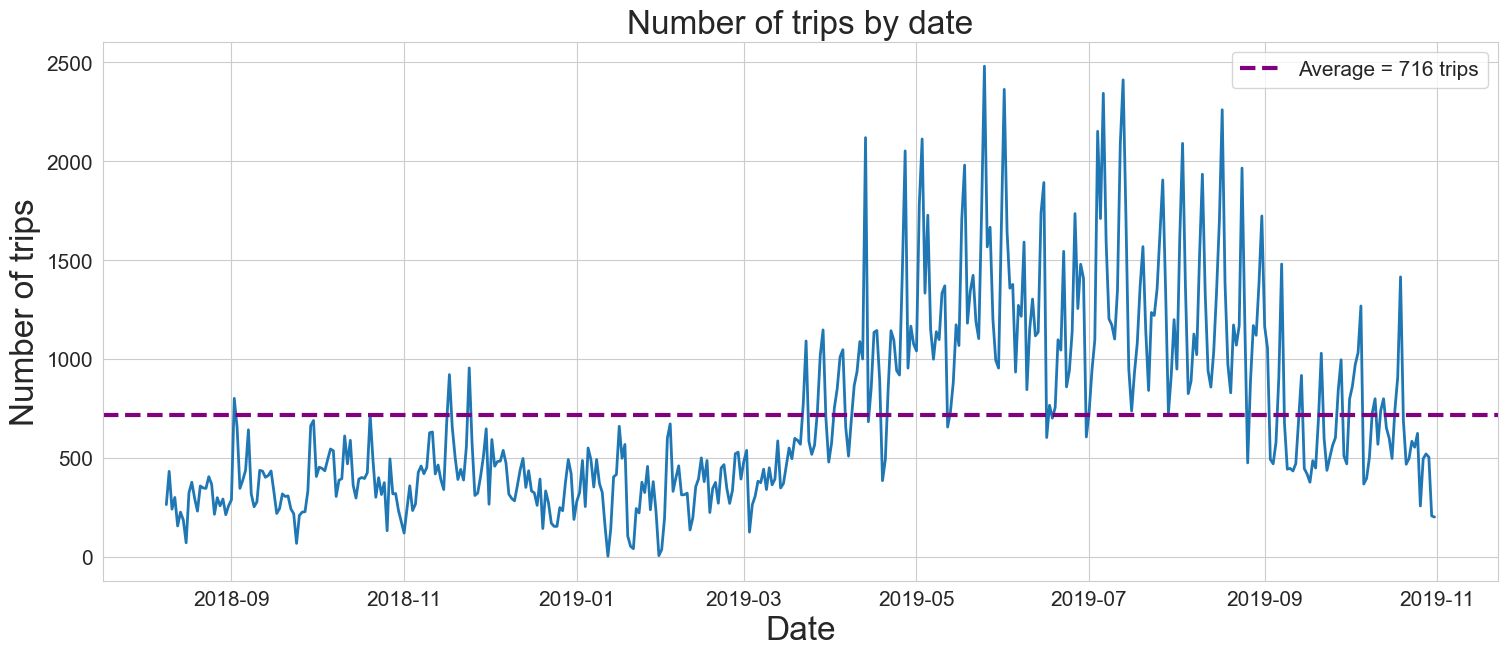

In [12]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trips", data=ntd, linewidth=2)
plot.axhline(atpd, linestyle="--", color="purple", label=f"Average = {atpd} trips", linewidth=3)
plt.title("Number of trips by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.2. Number of trips by day of week

#### Extracting day of week from Start Date column

In [13]:
df["Day of Week"] = df["StartDate"].dt.day_name()

In [14]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tdw = df.groupby("Day of Week")["Day of Week"].agg(["count"]).reindex(cats).reset_index()
tdw.columns = ["Day of Week", "Trips"]
tdw

Day of Week  Trips
0      Monday  36597
1     Tuesday  39179
2   Wednesday  41429
3    Thursday  44498
4      Friday  53016
5    Saturday  63570
6      Sunday  42671

#### Average trips per day of week

In [15]:
atdw = round(tdw["Trips"].mean())
print(f"Average trips per day of week: {atdw}")

Average trips per day of week: 45851


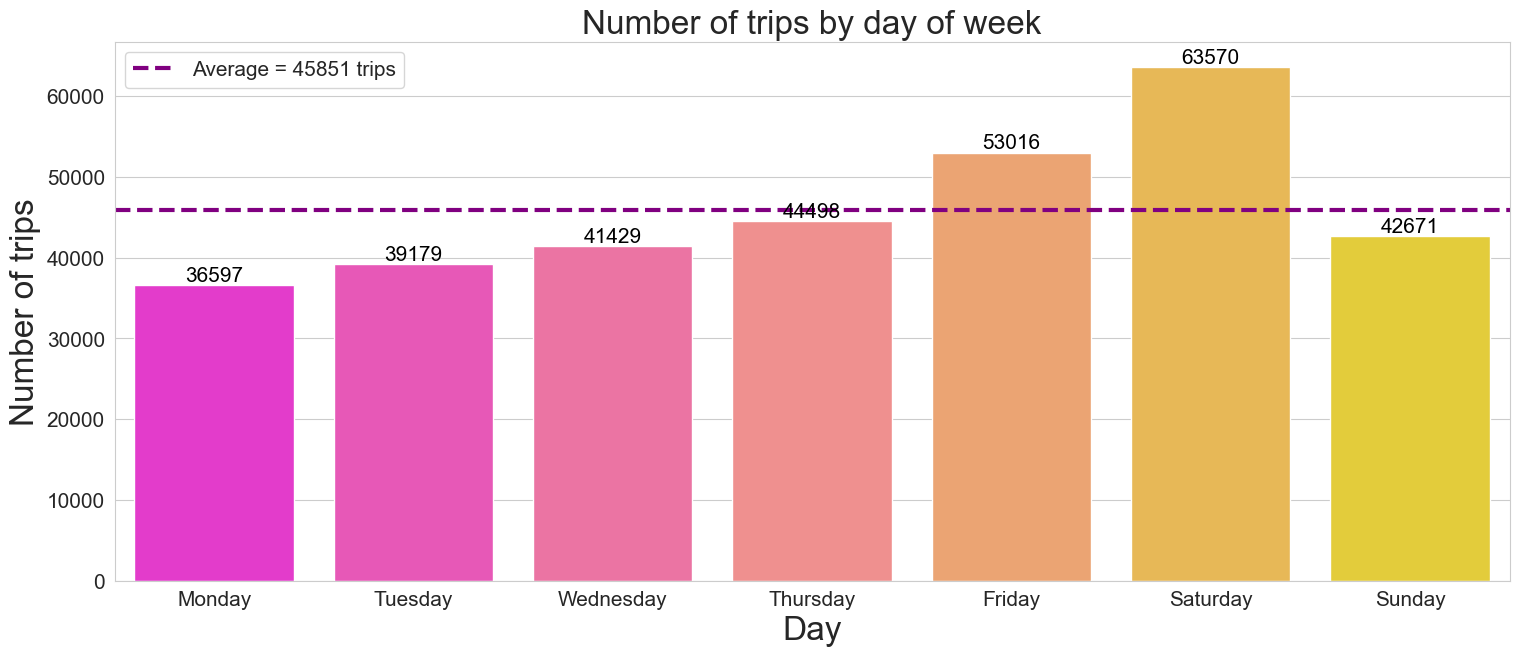

In [16]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Trips", data=tdw, palette="spring")
for p in plot.patches:
    plot.annotate('{:.0f}'.format(p.get_height()),
                  (p.get_x() + 0.4, p.get_height()),
                  ha='center', va='bottom', color='black', size=15)
plot.axhline(atdw, linestyle="--", color="purple", label=f"Average = {atdw} trips", linewidth=3)
plt.title("Number of trips by day of week", size=24)
plt.xlabel("Day", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.3. Distribution of trips over hours of the day

In [17]:
df["StartTime"] = np.where(df['StartTime']=='24:00', '00:00', df["StartTime"])
df["Hour"] = pd.to_datetime(df["StartTime"]).dt.hour

In [18]:
thd = df["Hour"].value_counts().to_frame().reset_index()
thd.columns = ["Hour", "Trips"]
thd

Hour  Trips
0     16  25552
1     15  25448
2     14  24611
3     13  24180
4     17  23760
5     12  23224
6     18  20374
7     11  20280
8     19  18930
9     20  17670
10    10  16840
11     9  14699
12     8  12326
13    21  10918
14     7   9098
15    22   7767
16     6   6071
17    23   5492
18     5   4494
19     4   3009
20     3   2096
21     0   1850
22     2   1170
23     1   1101

#### Average trips per hour

In [19]:
athd = round(thd["Trips"].mean())
print(f"Average trips per hour: {athd}")

Average trips per hour: 13373


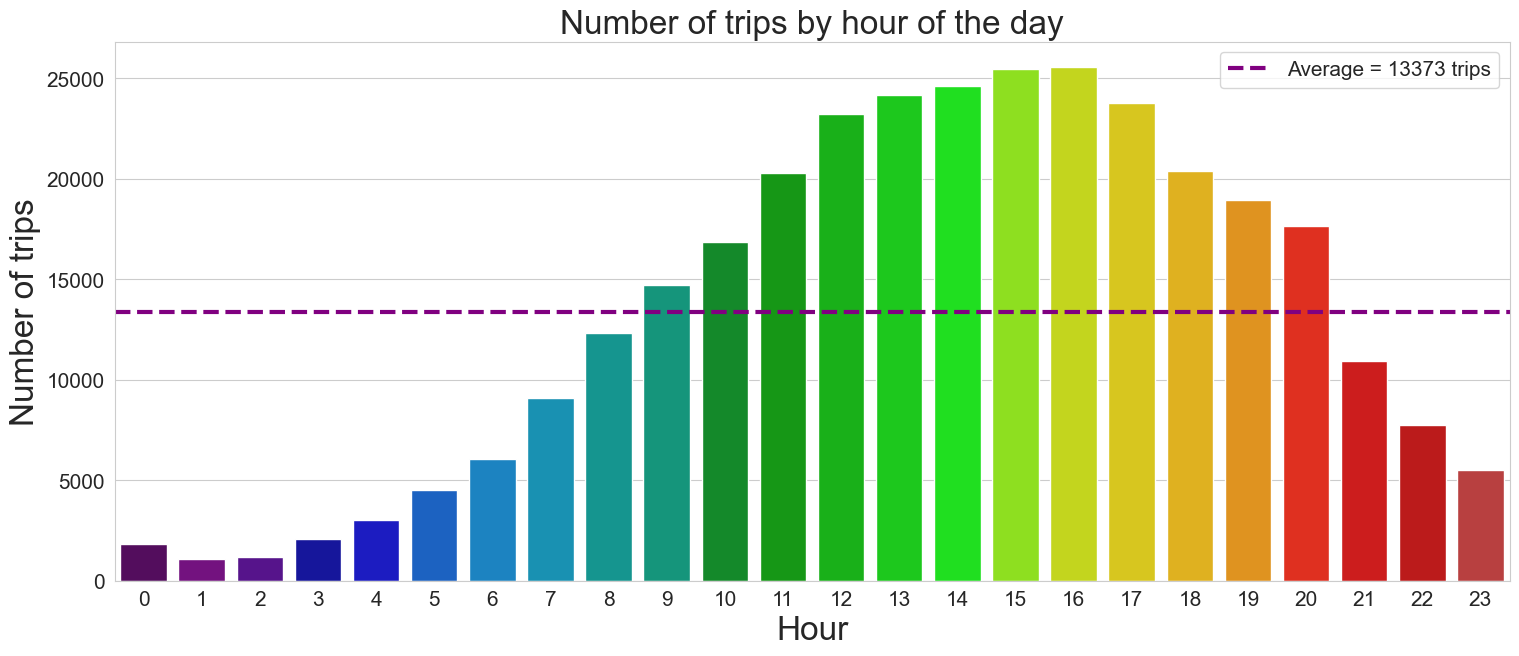

In [20]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Trips", data=thd, palette="nipy_spectral")
plot.axhline(athd, linestyle="--", color="purple", label=f"Average = {athd} trips", linewidth=3)
plt.title("Number of trips by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Number of trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 4.4. Number of trips by start area

#### Adding new columns with information about the neighbourhood that given location is in and coordinates describing the center of this neighbourhood

In [21]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

In [22]:
area_key = {}
area_idx = 0
for start_lat in df["StartLatitude"].values:
    if start_lat not in area_key:
        area_key[start_lat] = area_idx
        area_idx+=1
for end_lat in df["EndLatitude"].values:
    if end_lat not in area_key:
        area_key[end_lat] = area_idx
        area_idx+=1

In [24]:
from tqdm import tqdm
road_map = {}
area_coords = {}
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, start_lon, end_lat, end_lon = row.StartLatitude, row.StartLongitude, row.EndLatitude, row.EndLongitude
    if start_lat not in road_map:
        start_loc = geolocator.reverse(f"{start_lat},{start_lon}")
        if start_loc and 'road' in start_loc.raw['address']:
            start_loc = start_loc.raw
            start_neigh = start_loc['address']['road']
            road_map[start_lat] = start_neigh
            area_center = geolocator.geocode(f"Louisville {start_neigh}")
            if area_center:
                area_coords[start_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}
    if end_lat not in road_map:
        end_loc = geolocator.reverse(f"{end_lat},{end_lon}")
        if end_loc and 'road' in end_loc.raw['address']:
            end_loc = end_loc.raw
            end_neigh = end_loc['address']['road']
            road_map[end_lat] = end_neigh
            area_center = geolocator.geocode(f"Louisville {end_neigh}")
            if area_center:
                area_coords[end_neigh] = {'lat': area_center.latitude, 'lon': area_center.longitude}

28864it [02:55, 164.84it/s]


GeocoderUnavailable: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Louisville+North+Park+Avenue&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))

In [26]:
for row in tqdm(df.itertuples()):
    index = row.Index
    start_lat, end_lat = row.StartLatitude, row.EndLatitude
    if start_lat in road_map:
        start_neigh = road_map[start_lat]
        df.at[index, "Start Area Name"] = start_neigh
        if start_neigh in area_coords:
            df.at[index, "Start Centroid Latitude"] = area_coords[start_neigh]['lat']
            df.at[index, "Start Centroid Longitude"] = area_coords[start_neigh]['lon']
        
    if end_lat in road_map:
        end_neigh = road_map[end_lat]
        df.at[index, "End Area Name"] = end_neigh
        if end_neigh in area_coords:
            df.at[index, "End Centroid Latitude"] = area_coords[end_neigh]['lat']
            df.at[index, "End Centroid Longitude"] = area_coords[end_neigh]['lon']

320960it [00:29, 10744.22it/s]


In [27]:
ntbsa = df["Start Area Name"].value_counts().to_frame().reset_index()
ntbsa.columns = ["Start Area Name", "Trips"]
ntbsa

Start Area Name  Trips
0                     South 3rd Street  27299
1                 North Clifton Avenue  26711
2    LouieLink Downtown Skywalk System  26157
3                     East Main Street  22403
4              East Witherspoon Street  17799
..                                 ...    ...
114                      Carribean Way      1
115                   West 95th Street      1
116                         Ponder Way      1
117                       Nashua Drive      1
118                       Woehrle Road      1

[119 rows x 2 columns]

#### 4.5. Number of trips by destination area

In [28]:
ntbea = df["End Area Name"].value_counts().to_frame().reset_index()
ntbea.columns = ["End Area Name", "Trips"]
ntbea

End Area Name  Trips
0                     South 3rd Street  28834
1    LouieLink Downtown Skywalk System  23887
2                 North Clifton Avenue  23384
3                     East Main Street  21434
4                   West Market Street  16046
..                                 ...    ...
121                      Chesley Drive      1
122                       James Avenue      1
123                     Malcolm Avenue      1
124                    West 32nd Place      1
125                        Doris Drive      1

[126 rows x 2 columns]

### 5. Average trip speed (km/h)

#### Creating new column: Average Speed

In [29]:
df["Average Speed"] = df["TripDistance"] / (df["TripDuration"] / 60)

#### Average speed of trip

In [30]:
avs = round(df['Average Speed'].mean(), 2)
print(f"Average speed of trip: {avs} km/h")

Average speed of trip: 5.95 km/h


#### 5.1 Average speed by date

In [31]:
atsbd = df.groupby(["StartDate"]).agg({"Average Speed": "mean"}).reset_index()
atsbd.columns = ["Date", "Average Speed"]
atsbd["Average Speed"] = round(atsbd["Average Speed"], 2)
atsbd.head()

Date  Average Speed
0 2018-08-09           6.13
1 2018-08-10           6.36
2 2018-08-11           6.21
3 2018-08-12           6.57
4 2018-08-13           6.58

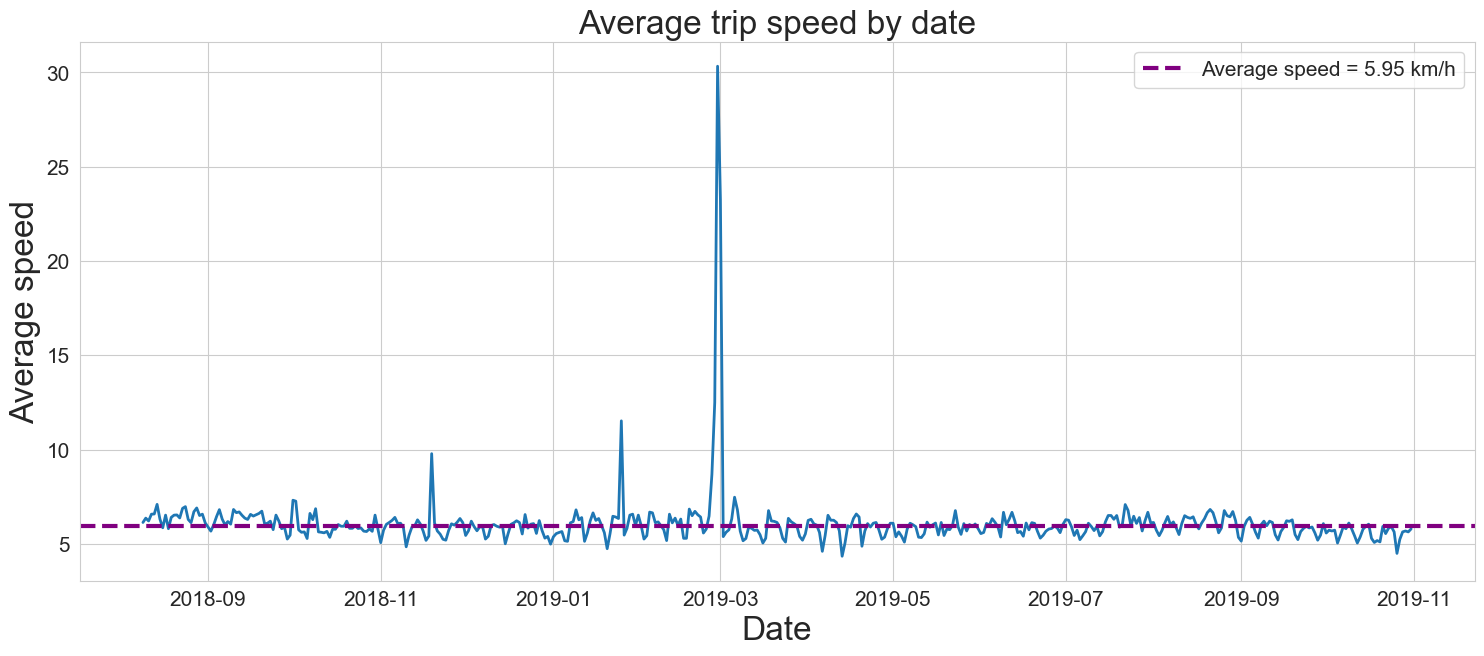

In [32]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Average Speed", data=atsbd, linewidth=2)
plot.axhline(avs, linestyle="--", color="purple", label=f"Average speed = {avs} km/h", linewidth=3)
plt.title("Average trip speed by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average speed", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.2 Average speed by day of week

In [33]:
aspd = df.groupby(["Day of Week"]).agg({"Average Speed": "mean"})
aspd.columns = ["Average Speed"]
aspd["Average Speed"] = round(aspd["Average Speed"], 2)
aspd = aspd.reset_index()
aspd

Day of Week  Average Speed
0      Friday           6.00
1      Monday           6.15
2    Saturday           5.43
3      Sunday           5.64
4    Thursday           6.28
5     Tuesday           6.21
6   Wednesday           6.22

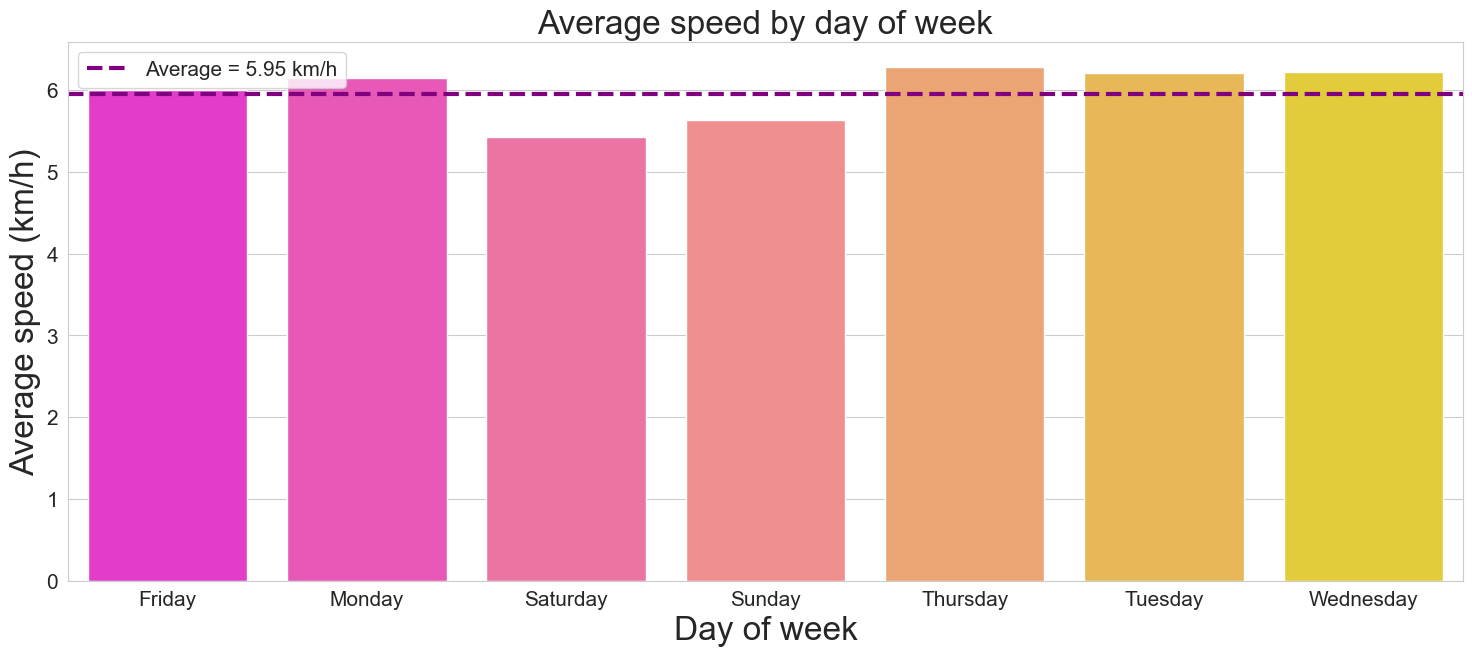

In [34]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Speed", data=aspd, palette="spring")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 5.3 Average speed by start hour

In [35]:
asph = df.groupby(["Hour"]).agg({"Average Speed": "mean"})
asph.columns = ["Average Speed"]
asph["Average Speed"] = round(asph["Average Speed"], 2)
asph = asph.reset_index()
asph

Hour  Average Speed
0      0           5.82
1      1           6.56
2      2           7.30
3      3           8.64
4      4           7.69
5      5           7.36
6      6           7.50
7      7           6.38
8      8           6.20
9      9           6.30
10    10           6.18
11    11           6.15
12    12           5.91
13    13           5.82
14    14           5.83
15    15           5.66
16    16           5.59
17    17           5.70
18    18           5.69
19    19           5.75
20    20           5.64
21    21           5.60
22    22           5.93
23    23           5.84

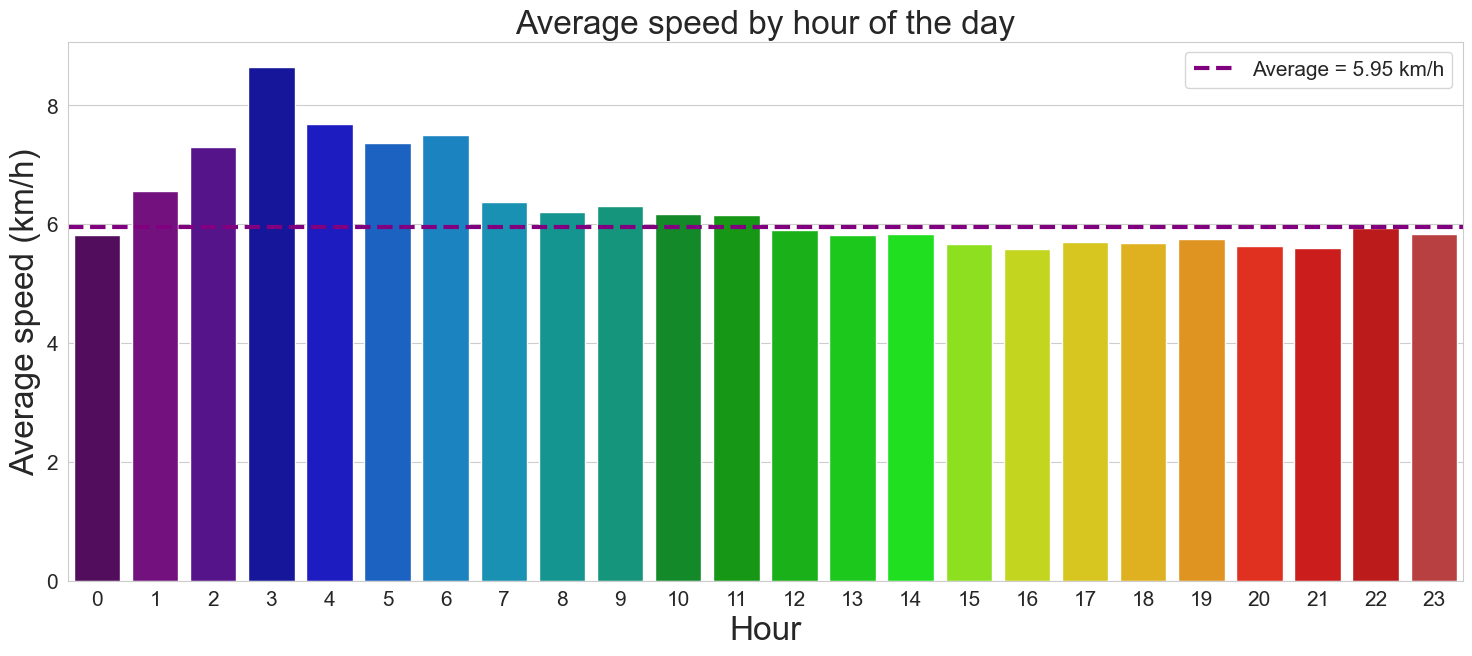

In [36]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Speed", data=asph, palette="nipy_spectral")
plot.axhline(avs, linestyle="--", color="purple", label=f"Average = {avs} km/h", linewidth=3)
plt.title("Average speed by hour of the day", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average speed (km/h)", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 6. Average trip distance

In [37]:
avd = round(df["TripDistance"].mean(), 2)
print(f"Average distance per trip: {avd}km")

Average distance per trip: 1.47km


#### 6.1. Average trip distance by date

In [38]:
atdbd = df.groupby(["StartDate"]).agg({"TripDistance": "mean"}).reset_index()
atdbd.columns = ["Date", "Trip Distance"]
atdbd["Trip Distance"] = round(atdbd["Trip Distance"], 2)
atdbd.head()

Date  Trip Distance
0 2018-08-09           1.93
1 2018-08-10           1.69
2 2018-08-11           2.54
3 2018-08-12           2.58
4 2018-08-13           2.50

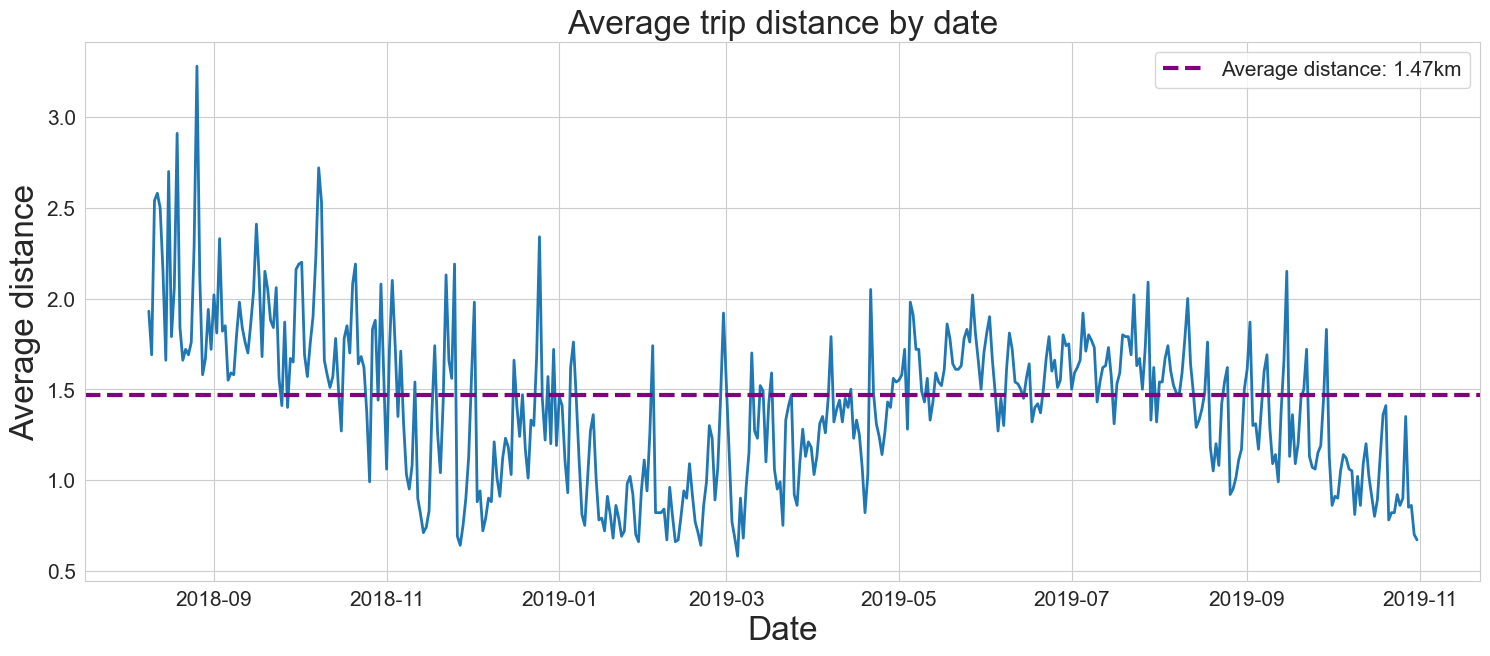

In [39]:
plt.figure(figsize=(18, 7))
plot = sns.lineplot(x="Date", y="Trip Distance", data=atdbd, linewidth=2)
plot.axhline(avd, linestyle="--", color="purple", label=f"Average distance: {avd}km", linewidth=3)
plt.title("Average trip distance by date", size=24)
plt.xlabel("Date", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.2. Average trip distance by day of week

In [40]:
adbd = df.groupby(["Day of Week"]).agg({"TripDistance": "mean"})
adbd.columns = ["Average Trip Distance"]
adbd["Average Trip Distance"] = round(adbd["Average Trip Distance"], 2)
adbd = adbd.reset_index()
adbd

Day of Week  Average Trip Distance
0      Friday                   1.43
1      Monday                   1.46
2    Saturday                   1.57
3      Sunday                   1.76
4    Thursday                   1.34
5     Tuesday                   1.38
6   Wednesday                   1.33

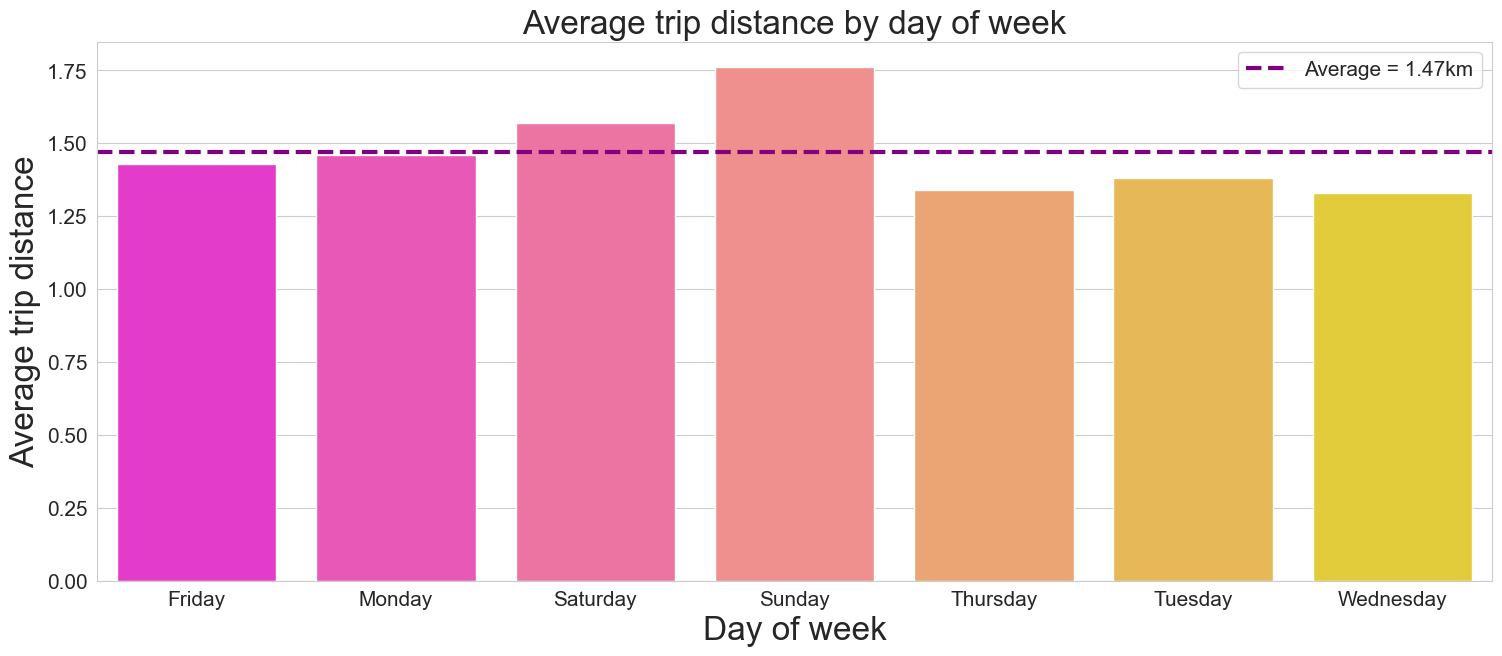

In [41]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Day of Week", y="Average Trip Distance", data=adbd, palette="spring")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}km", linewidth=3)
plt.title("Average trip distance by day of week", size=24)
plt.xlabel("Day of week", size=24)
plt.ylabel("Average trip distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 6.3. Average trip distance by hour of the day

In [42]:
adbh = df.groupby(["Hour"]).agg({"TripDistance": "mean"})
adbh.columns = ["Average Trip Distance"]
adbh["Average Trip Distance"] = round(adbh["Average Trip Distance"], 2)
adbh = adbh.reset_index()
adbh

Hour  Average Trip Distance
0      0                   1.84
1      1                   1.71
2      2                   1.68
3      3                   1.25
4      4                   1.26
5      5                   1.09
6      6                   1.11
7      7                   1.12
8      8                   1.14
9      9                   1.22
10    10                   1.32
11    11                   1.36
12    12                   1.39
13    13                   1.45
14    14                   1.53
15    15                   1.53
16    16                   1.57
17    17                   1.53
18    18                   1.58
19    19                   1.64
20    20                   1.67
21    21                   1.69
22    22                   1.81
23    23                   1.79

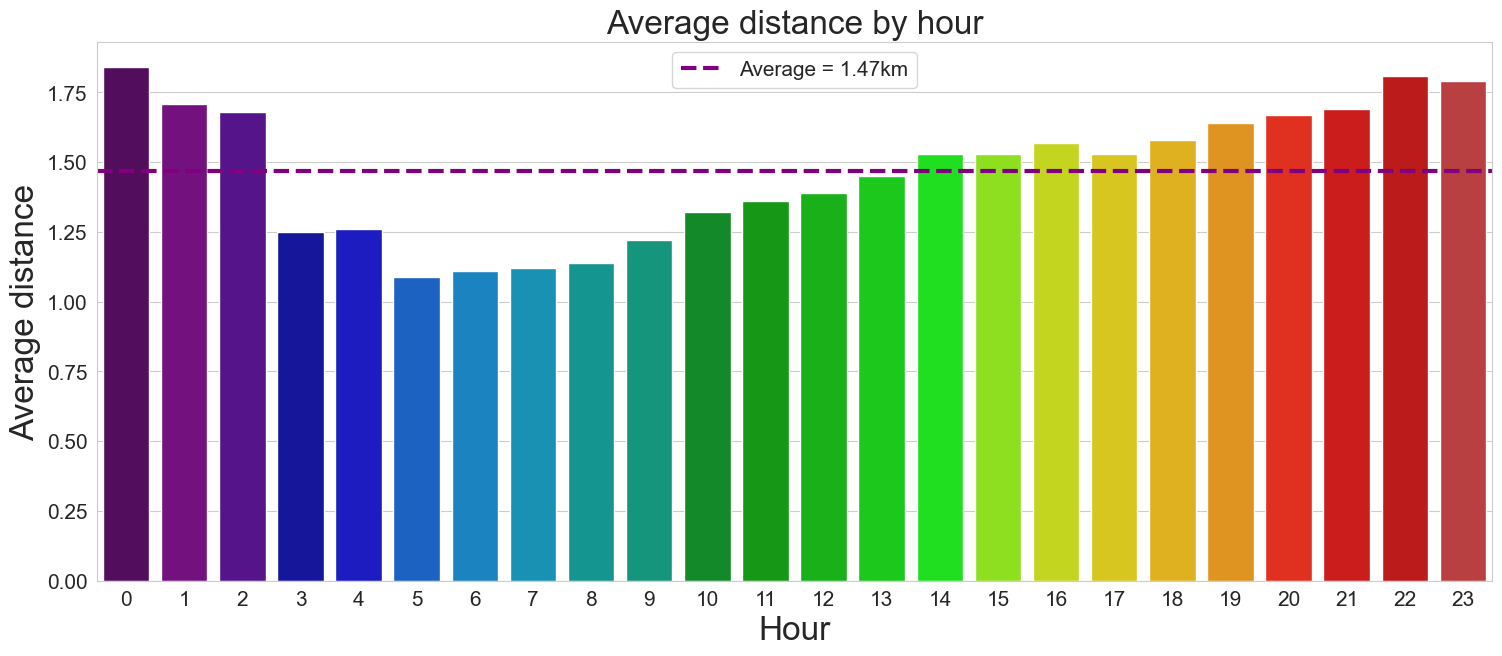

In [43]:
plt.figure(figsize=(18, 7))
plot = sns.barplot(x="Hour", y="Average Trip Distance", data=adbh, palette="nipy_spectral")
plot.axhline(avd, linestyle="--", color="purple", label=f"Average = {avd}km", linewidth=3)
plt.title("Average distance by hour", size=24)
plt.xlabel("Hour", size=24)
plt.ylabel("Average distance", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 7. Trips statistics for first and last 15 days

#### First 15 days

In [44]:
ftd = df[(df["StartDate"] >= "2018-08-09") & (df["StartDate"] <= "2018-08-22")]
ftd["Time Period"] = "First 15 Days"

#### Last 15 days

In [45]:
ltd = df[(df["StartDate"] >= "2019-10-18") & (df["StartDate"] <= "2019-10-31")]
ltd["Time Period"] = "Last 15 Days"

In [46]:
fltd = pd.concat([ftd, ltd])

#### 7.1. Statistics by time period

In [47]:
fl_15 = fltd.groupby("Time Period").agg({"Time Period": "count",
                                         "TripDistance": "mean",
                                         "TripDuration": "mean",
                                         "Average Speed": "mean"})
fl_15.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fl_15["Trips Distance"] = round(fl_15["Trips Distance"], 2)
fl_15["Trips Duration"] = round(fl_15["Trips Duration"], 2)
fl_15["Average Speed"] = round(fl_15["Average Speed"], 2)
fl_15 = fl_15.reset_index()
fl_15

Time Period  Trips  Trips Distance  Trips Duration  Average Speed
0  First 15 Days   3824            2.06           21.34           6.38
1   Last 15 Days   7940            1.04           13.71           5.43

#### 7.2. Statistics by day of week and time period

In [48]:
fltdg = fltd.groupby(["Day of Week", "Time Period"]).agg({"Time Period": "count",
                                                          "TripDistance": "mean",
                                                          "TripDuration": "mean",
                                                          "Average Speed": "mean"})
fltdg.columns = ["Trips", "Trips Distance", "Trips Duration", "Average Speed"]
fltdg["Trips Distance"] = round(fltdg["Trips Distance"], 2)
fltdg["Trips Duration"] = round(fltdg["Trips Duration"], 2)
fltdg["Average Speed"] = round(fltdg["Average Speed"], 2)
fltdg = fltdg.reset_index()
fltdg

Day of Week    Time Period  Trips  Trips Distance  Trips Duration  \
0       Friday  First 15 Days    758            1.73           17.36   
1       Friday   Last 15 Days   1534            1.02           13.79   
2       Monday  First 15 Days    389            2.11           20.44   
3       Monday   Last 15 Days    990            0.82           10.35   
4     Saturday  First 15 Days    620            2.24           25.69   
5     Saturday   Last 15 Days   1674            1.29           17.89   
6       Sunday  First 15 Days    598            2.75           27.92   
7       Sunday   Last 15 Days   1189            1.39           18.72   
8     Thursday  First 15 Days    337            2.09           21.58   
9     Thursday   Last 15 Days    757            0.85            9.45   
10     Tuesday  First 15 Days    586            1.85           17.85   
11     Tuesday   Last 15 Days   1003            0.84           10.58   
12   Wednesday  First 15 Days    536            1.70           18.92   
13   Wednesday   Last 15 Days    793            0.79            9.49   

    Average Speed  
0            6.43  
1            5.30  
2            6.55  
3            5.77  
4            5.96  
5            5.06  
6            6.48  
7            5.16  
8            6.07  
9            5.88  
10           6.75  
11           5.61  
12           6.35  
13           5.77

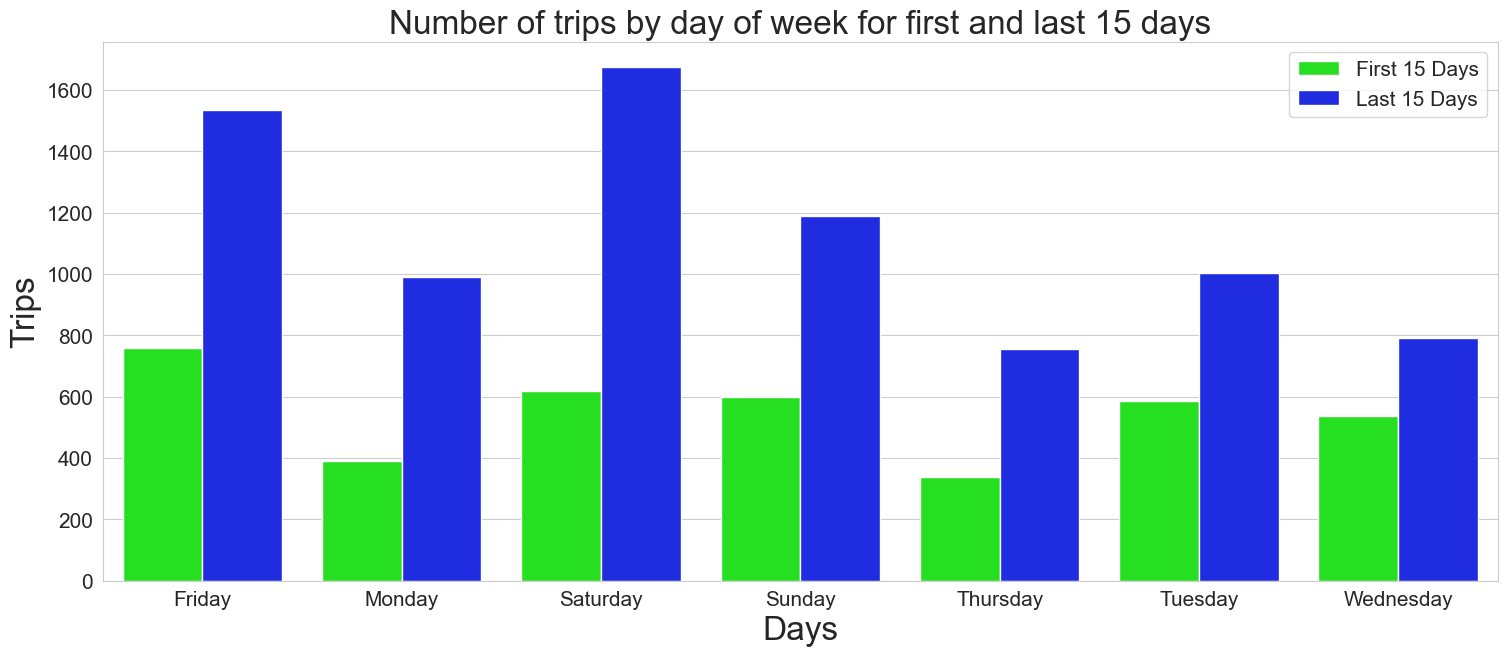

In [49]:
plt.figure(figsize=(18, 7))
sns.barplot(x="Day of Week", y="Trips", hue="Time Period", data=fltdg, palette="hsv")
plt.title("Number of trips by day of week for first and last 15 days", size=24)
plt.xlabel("Days", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

#### 7.3. Statistics by hour and time period

In [50]:
fltdh = fltd.groupby(["Hour", "Time Period"])["Time Period"].agg(["count"]).reset_index()
fltdh.columns = ["Hour", "Time Period", "Trips"]
fltdh

Hour    Time Period  Trips
0      5  First 15 Days      9
1      6  First 15 Days     11
2      6   Last 15 Days     57
3      7  First 15 Days     33
4      7   Last 15 Days    158
5      8  First 15 Days     67
6      8   Last 15 Days    254
7      9  First 15 Days     90
8      9   Last 15 Days    385
9     10  First 15 Days    116
10    10   Last 15 Days    383
11    11  First 15 Days    276
12    11   Last 15 Days    482
13    12  First 15 Days    362
14    12   Last 15 Days    589
15    13  First 15 Days    350
16    13   Last 15 Days    640
17    14  First 15 Days    362
18    14   Last 15 Days    678
19    15  First 15 Days    387
20    15   Last 15 Days    751
21    16  First 15 Days    380
22    16   Last 15 Days    838
23    17  First 15 Days    389
24    17   Last 15 Days    762
25    18  First 15 Days    352
26    18   Last 15 Days    719
27    19  First 15 Days    346
28    19   Last 15 Days    599
29    20  First 15 Days    265
30    20   Last 15 Days    509
31    21  First 15 Days     29
32    21   Last 15 Days    131
33    22   Last 15 Days      5

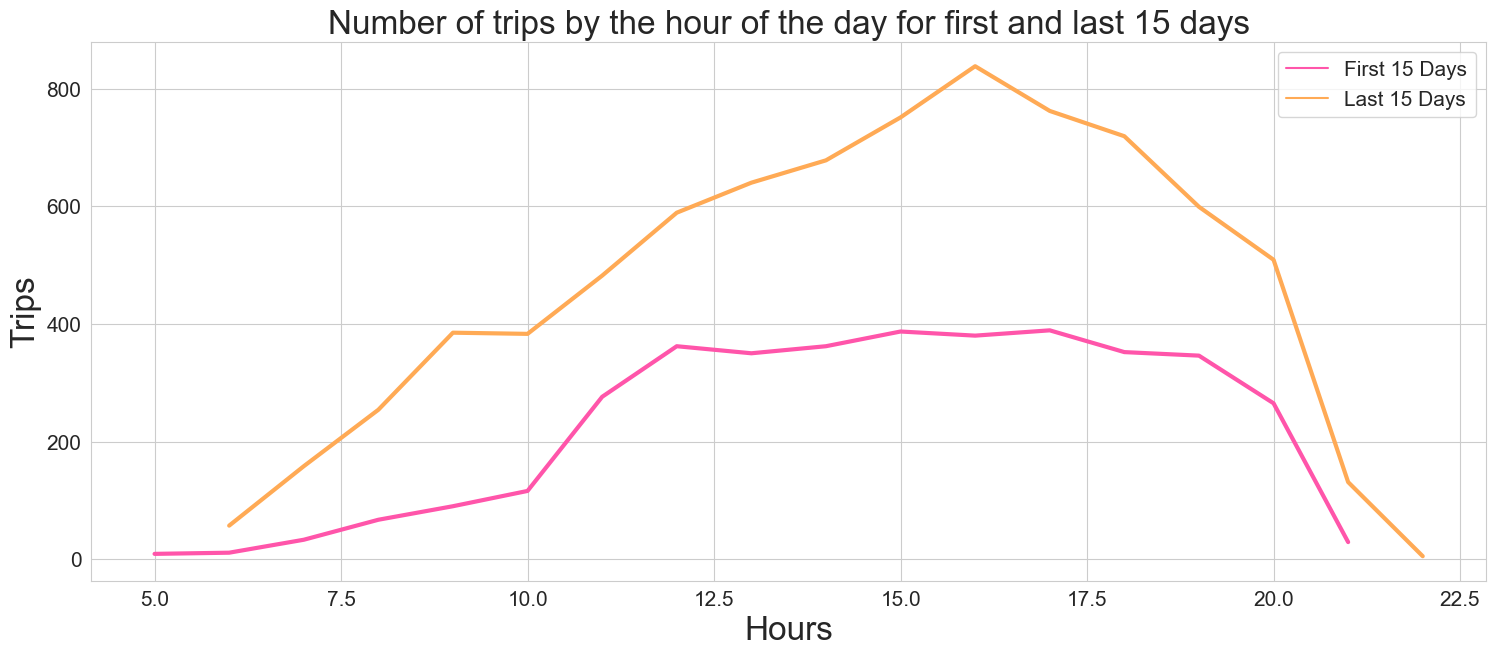

In [51]:
plt.figure(figsize=(18, 7))
sns.lineplot(x="Hour", y="Trips", hue="Time Period", data=fltdh, palette="spring", linewidth=3)
plt.title("Number of trips by the hour of the day for first and last 15 days", size=24)
plt.xlabel("Hours", size=24)
plt.ylabel("Trips", size=24)
plt.legend(prop={'size': 15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

### 8. Starts analysis


#### 8.1. Starts count on map

In [52]:
df_location_start = df[['Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
df_location_start, counts_start = np.unique(df_location_start, return_counts=True, axis=0)
df_location_start = np.append(df_location_start, counts_start.reshape((df_location_start.shape[0], -1)), axis=1)

In [53]:
def draw_starts_number_map(data):
    location_start_map = folium.Map(location=[38.259, -85.677], zoom_start=12)
    for row in data:
        lat = row[0]
        long = row[1]
        count = row[2]
        radius = count / 3500
        color = "#FF4500"
        popup_text = """Latitude : {}<br>
                    Longitude : {}<br>
                    Starts numer : {}<br>"""
        popup_text = popup_text.format(lat, long, count)
        folium.CircleMarker(location=(lat, long), fill=True, radius=radius, popup=popup_text, color=color).add_to(
            location_start_map)
    return location_start_map


draw_starts_number_map(df_location_start)

#### 8.1. Put back location

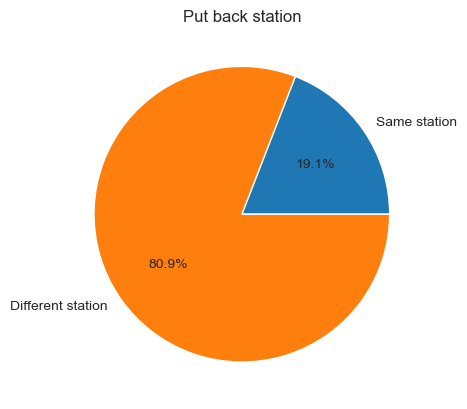

In [54]:
areas = df[["Start Area Name", 'End Area Name']].value_counts().to_frame().reset_index()
areas.columns = ["Start Area Name", 'End Area Name', "count"]
same_district = areas[(areas["Start Area Name"] == areas['End Area Name'])].reset_index()
different_district = areas[(areas["Start Area Name"] != areas['End Area Name'])].reset_index()

fig, ax = plt.subplots()
ax.pie([same_district["count"].sum(), different_district["count"].sum()],
       labels=["Same station", "Different station"], autopct='%1.1f%%')
plt.title("Put back station")
plt.show()

### 9. Traffic flow analysis


In [55]:
areas = df[["Start Area Name", 'End Area Name']].dropna()
unique_areas = np.unique(areas)
area_count = unique_areas.shape[0]

areas_map = {}
for i, area_no in enumerate(unique_areas):
    areas_map[area_no] = i

different_district = areas[
    (areas["Start Area Name"] != areas['End Area Name'])]  #.reset_index()

transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)
for i, trip in enumerate(different_district.iloc):
    t0 = np.str(trip[0])
    t1 = np.str(trip[1])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [56]:
transfer_arr_norm = transfer_arr / np.linalg.norm(transfer_arr)
print(transfer_arr_norm.shape)

(128, 128)


In [57]:
area_geo_start_position = df[['Start Area Name', 'Start Centroid Latitude', 'Start Centroid Longitude']].dropna()
area_geo_start_position = area_geo_start_position.drop_duplicates(subset="Start Area Name")
area_geo_start_position = area_geo_start_position.sort_values(by=['Start Area Name'])
area_geo_start_position = np.array(area_geo_start_position)
area_geo_end_position = df[['End Area Name', 'End Centroid Latitude', 'End Centroid Longitude']].dropna()
area_geo_end_position = area_geo_end_position.drop_duplicates(subset="End Area Name")
area_geo_end_position = area_geo_end_position.sort_values(by=['End Area Name'])
area_geo_end_position = np.array(area_geo_end_position)
area_geo_position = np.concatenate((area_geo_start_position,area_geo_end_position),0)

In [58]:
list_colors = [
    "#00FF00",
    "#12FF00",
    "#24FF00",
    "#35FF00",
    "#47FF00",
    "#58FF00",
    "#6AFF00",
    "#7CFF00",
    "#8DFF00",
    "#9FFF00",
    "#B0FF00",
    "#C2FF00",
    "#D4FF00",
    "#E5FF00",
    "#F7FF00",
    "#FFF600",
    "#FFE400",
    "#FFD300",
    "#FFC100",
    "#FFAF00",
    "#FF9E00",
    "#FF8C00",
    "#FF7B00",
    "#FF6900",
    "#FF5700",
    "#FF4600",
    "#FF3400",
    "#FF2300",
    "#FF1100",
    "#FF0011",
    "#FF0023",
    "#FF0034",
    "#FF0046",
    "#FF0057",
    "#FF0069",
    "#FF007B",
    "#FF008C",
    "#FF009E",
    "#FF00AF",
    "#FF00C1",
    "#FF00D3",
    "#FF00E4",
    "#FF00F6",
    "#F700FF",
    "#E500FF",
    "#D400FF",
]
color_dict = {i: list_colors[i] for i in range(len(list_colors))}

In [59]:
def draw_flow_map(treshold=1):
    max_count = np.max(transfer_arr)
    print(max_count)
    location_start_map = folium.Map(location=[38.259, -85.677], zoom_start=12)
    for y in range(transfer_arr.shape[0]):
        for x in range(transfer_arr.shape[1]):
            if x > y and np.abs(transfer_arr[x, y]) > max_count * treshold:
                start_lat = area_geo_position[x, 1]
                start_long = area_geo_position[x, 2]
                end_lat = area_geo_position[y, 1]
                end_long = area_geo_position[y, 2]

                coordinates = [
                    [start_lat, start_long],
                    [end_lat, end_long]
                ]

                color = np.floor(np.log(np.abs(transfer_arr[x, y])) * (30 / np.ceil(np.log(max_count))))
                line = folium.PolyLine(locations=coordinates, weight=color / 2, color=color_dict[color])
                location_start_map.add_child(line)

                geodesic = Geod(ellps='WGS84')
                if transfer_arr[x, y] > 0:
                    rotation = geodesic.inv(start_long, start_lat, end_long, end_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(location=(
                    (end_lat - start_lat) * 0.95 + start_lat, (end_long - start_long) * 0.95 + start_long),
                                                             color=color_dict[color], number_of_sides=3,
                                                             radius=color * 0.75, rotation=rotation)
                else:
                    rotation = geodesic.inv(end_long, end_lat, start_long, start_lat)[0] - 90
                    arrow_head = folium.RegularPolygonMarker(
                        location=((start_lat - end_lat) * 0.95 + end_lat, (start_long - end_long) * 0.95 + end_long),
                        color=color_dict[color], number_of_sides=3, radius=color * 0.75, rotation=rotation)
                location_start_map.add_child(arrow_head)
    return location_start_map

In [60]:
draw_flow_map(0.01)

3921


#### 9.1. Traffic flow - morning

In [61]:
def parseDateTime(dateTime: str, fromTime: int, toTime: int):
    result = []
    for dT in dateTime:
        hour = int(dT.split(':')[0])
        if fromTime <= hour <= toTime:
            result.append(True)
        else:
            result.append(False)
    return np.array(result)

In [62]:
areas = df[["StartTime", "Start Area Name", "End Area Name"]].dropna()
district_filter = np.array(areas["Start Area Name"] != areas['End Area Name'])
hour_filter = parseDateTime(areas['StartTime'], 10, 14)
sum_filter = []
for i in range(len(district_filter)):
    if district_filter[i] == True and hour_filter[i] == True:
        sum_filter.append(True)
    else:
        sum_filter.append(False)
hour_district = np.array(areas[sum_filter])
transfer_arr = np.zeros(shape=(area_count, area_count), dtype=np.int32)

for i, trip in enumerate(hour_district):
    t0 = np.str(trip[1])
    t1 = np.str(trip[2])
    if t0 > t1:
        transfer_arr[areas_map[t0], areas_map[t1]] += 1
    else:
        transfer_arr[areas_map[t0], areas_map[t1]] -= 1

In [63]:
draw_flow_map(0.01)

1547


#### 9.2. Traffic flow - afternoon


In [64]:
draw_flow_map(0.01)

1547


#### 9.3 Traffic flow per hour


In [65]:
start_area = df[['Start Area Name', 'Hour']].groupby(
    ["Start Area Name", "Hour"]).value_counts().reset_index()
start_area.columns = ["Area", "Hour", "Trips"]
start_area["Type"] = ["Start"] * len(start_area)
end_area = df[['End Area Name', 'Hour']].groupby(
    ["End Area Name", "Hour"]).value_counts().reset_index()
end_area.columns = ["Area", "Hour", "Trips"]
end_area["Type"] = ["End"] * len(end_area)
area_hour_start_end = pd.concat([start_area, end_area])
area_hour_start_end

Area  Hour  Trips   Type
0     Abraham Flexner Way     0     66  Start
1     Abraham Flexner Way     1     19  Start
2     Abraham Flexner Way     2     21  Start
3     Abraham Flexner Way     3     36  Start
4     Abraham Flexner Way     4     59  Start
...                   ...   ...    ...    ...
1982          Zorn Avenue    19     46    End
1983          Zorn Avenue    20     51    End
1984          Zorn Avenue    21     24    End
1985          Zorn Avenue    22     20    End
1986          Zorn Avenue    23     17    End

[3781 rows x 4 columns]

In [66]:
def plot_area_hour_start_end(district):
    plt.figure(figsize=(13, 5))
    sns.barplot(x="Hour", y="Trips", hue="Type", data=area_hour_start_end[area_hour_start_end['Area'] == district],
                palette="hsv")
    plt.title(f'Number of starts and ends by hour in {district}', size=24)
    plt.xlabel("Hours", size=24)
    plt.ylabel("Trips", size=24)
    plt.legend(prop={'size': 15})
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.show()

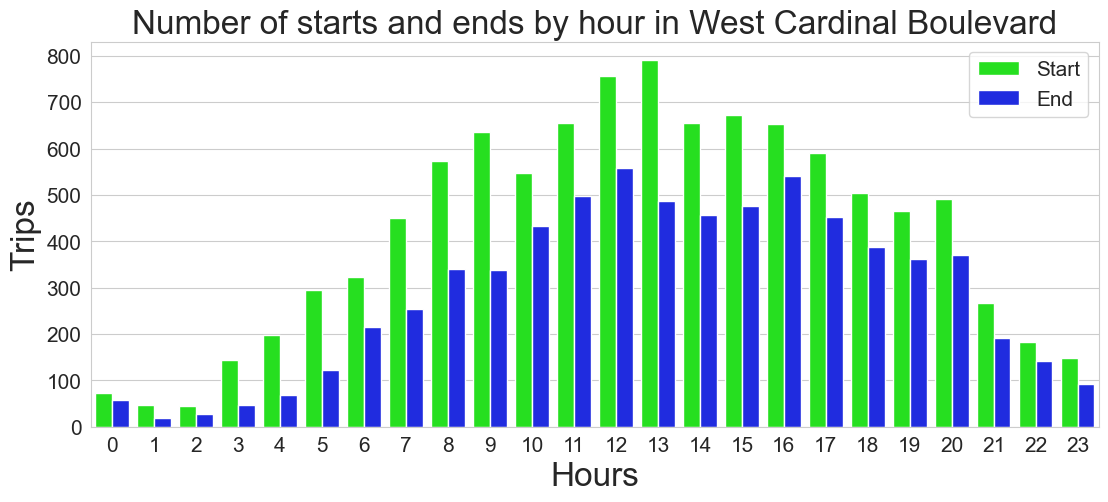

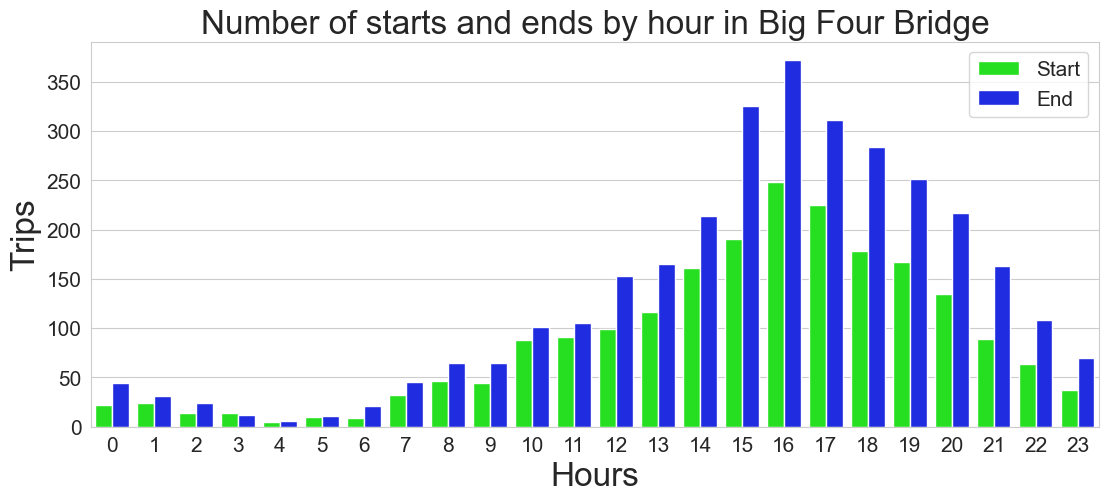

In [67]:
districts = ["West Cardinal Boulevard","Big Four Bridge"]
for district in districts:
    plot_area_hour_start_end(district)

### Predictions

In [68]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib.pyplot import figure
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.ensemble import RandomForestClassifier

In [69]:
df.columns

Index(['TripID', 'StartDate', 'StartTime', 'EndDate', 'EndTime',
       'TripDuration', 'TripDistance', 'StartLatitude', 'StartLongitude',
       'EndLatitude', 'EndLongitude', 'DayOfWeek', 'HourNum', 'Day of Week',
       'Hour', 'Start Area Name', 'Start Centroid Latitude',
       'Start Centroid Longitude', 'End Area Name', 'End Centroid Latitude',
       'End Centroid Longitude', 'Average Speed'],
      dtype='object')

### Predictions of trip destination point

In [114]:
features = ['TripDuration', 'TripDistance', 'Start Area Name', 'End Area Name', 'Day of Week', 'HourNum', 'End Centroid Longitude', 'Start Centroid Longitude']
filtered = df[features].dropna()
filtered = filtered[filtered['End Centroid Longitude'] < -85]
filtered = filtered[filtered['Start Centroid Longitude'] < -85]

le = preprocessing.LabelEncoder()
X = filtered[['TripDuration', 'TripDistance', 'Start Area Name', 'Day of Week', 'HourNum']]

le.fit(X['Day of Week'])
X['Day of Week'] = le.transform(X['Day of Week'])

le.fit(pd.concat([filtered['Start Area Name'],filtered['End Area Name']]))
X['Start Area Name'] = le.transform(X['Start Area Name'])
Y = le.transform(filtered['End Area Name'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [115]:
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, Y_train)

predictions = decision_tree.predict(X_test)

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.09      0.08      0.08      1942
           1       0.06      0.06      0.06       333
           2       0.00      0.00      0.00        15
           3       0.12      0.13      0.12      1250
           4       0.20      0.20      0.20      2675
           5       0.10      0.10      0.10       703
           6       0.00      0.00      0.00        12
           7       0.18      0.18      0.18       649
           8       1.00      1.00      1.00         2
           9       0.09      0.09      0.09       340
          11       0.07      0.07      0.07      1218
          12       0.00      0.00      0.00         7
          13       0.06      0.06      0.06       539
          14       0.11      0.11      0.11       312
          16       0.05      0.04      0.04        50
          17       0.05      0.04      0.05       378
          18       0.09      0.09      0.09       278
          19       0.04    

In [116]:
knn = KNeighborsClassifier()
knn = knn.fit(X_train, Y_train)

predictions = knn.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.07      0.16      0.09      1942
           1       0.04      0.07      0.05       333
           2       0.00      0.00      0.00        15
           3       0.09      0.17      0.11      1250
           4       0.17      0.40      0.24      2675
           5       0.04      0.06      0.05       703
           6       0.00      0.00      0.00        12
           7       0.13      0.22      0.16       649
           8       0.00      0.00      0.00         2
           9       0.06      0.08      0.07       340
          10       0.00      0.00      0.00         0
          11       0.05      0.08      0.06      1218
          12       0.00      0.00      0.00         7
          13       0.05      0.05      0.05       539
          14       0.07      0.08      0.08       312
          16       0.00      0.00      0.00        50
          17       0.03      0.03      0.03       378
          18       0.07    

In [117]:
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_train, Y_train)

predictions = random_forest.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.11      0.09      0.10      1942
           1       0.13      0.09      0.10       333
           2       0.25      0.07      0.11        15
           3       0.14      0.11      0.12      1250
           4       0.23      0.34      0.27      2675
           5       0.14      0.10      0.12       703
           6       0.00      0.00      0.00        12
           7       0.28      0.26      0.27       649
           8       0.00      0.00      0.00         2
           9       0.13      0.09      0.10       340
          10       0.00      0.00      0.00         0
          11       0.09      0.06      0.07      1218
          12       1.00      0.14      0.25         7
          13       0.09      0.06      0.07       539
          14       0.16      0.10      0.12       312
          16       0.00      0.00      0.00        50
          17       0.05      0.02      0.03       378
          18       0.11    

#### Predictions of trips duration

W zamyśle dzielimy czas przejazdu na 3 klasy, poniżej 10 min (krótki), powyżej 10 ale poniżej 25 min (średni) oraz przejazdy powyżej 25 min (długie)

In [118]:
tripDurationClass = np.where(filtered['TripDuration'] <= 10, 0, np.where(filtered['TripDuration'] <= 15, 1, 2))
print(np.unique(tripDurationClass, return_counts=True))

(array([0, 1, 2]), array([158034,  44927, 110505]))


In [119]:
features = ['TripDistance', 'Start Area Name', 'End Area Name', 'Day of Week', 'HourNum']

le = preprocessing.LabelEncoder()
tmp = df.dropna()
X = filtered[features]

le.fit(X['Day of Week'])
X['Day of Week'] = le.transform(X['Day of Week'])

le.fit(pd.concat([X['Start Area Name'],X['End Area Name']]))
X['Start Area Name'] = le.transform(X['Start Area Name'])
X['End Area Name']  = le.transform(X['End Area Name'])

Y = tripDurationClass

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

In [120]:
decision_tree = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, Y_train)

predictions = decision_tree.predict(X_test)

print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.76      0.77     31485
           1       0.25      0.27      0.26      8965
           2       0.71      0.70      0.70     22244

    accuracy                           0.67     62694
   macro avg       0.58      0.58      0.58     62694
weighted avg       0.67      0.67      0.67     62694



In [121]:
knn = KNeighborsClassifier()
knn = knn.fit(X_train, Y_train)

predictions = knn.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.91      0.80     31485
           1       0.29      0.16      0.21      8965
           2       0.82      0.66      0.73     22244

    accuracy                           0.71     62694
   macro avg       0.61      0.58      0.58     62694
weighted avg       0.69      0.71      0.69     62694



In [122]:
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(X_train, Y_train)

predictions = random_forest.predict(X_test)
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84     31485
           1       0.34      0.18      0.23      8965
           2       0.77      0.76      0.77     22244

    accuracy                           0.75     62694
   macro avg       0.63      0.61      0.61     62694
weighted avg       0.72      0.75      0.73     62694



### 11.0 Transfers Vector Map

In [88]:
def intersect_ellipse_section(cx, cy, a, b, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    
    # Define the coefficients for the quadratic equation
    A = dx**2 / a**2 + dy**2 / b**2
    B = 2 * x1 * dx / a**2 + 2 * y1 * dy / b**2
    C = x1**2 / a**2 + y1**2 / b**2 - 1
    
    # Calculate the discriminant
    discriminant = B**2 - 4 * A * C
    
    if discriminant < 0:
        # No intersection
        return None
    elif discriminant == 0:
        # One intersection point
        t = -B / (2 * A)
        if 0 <= t <= 1:
            x = x1 + t * dx
            y = y1 + t * dy
            return [(x, y)]
    else:
        # Two intersection points
        t1 = (-B + np.sqrt(discriminant)) / (2 * A)
        t2 = (-B - np.sqrt(discriminant)) / (2 * A)
        
        intersect_points = []
        if 0 <= t1 <= 1:
            x1 = x1 + t1 * dx
            y1 = y1 + t1 * dy
            intersect_points.append((x1, y1))
        if 0 <= t2 <= 1:
            x2 = x1 + t2 * dx
            y2 = y1 + t2 * dy
            intersect_points.append((x2, y2))
            
        return intersect_points

In [89]:
def draw_varctor_map(latMin, latMax, lonMin, lonMax, vectorMapData):
    
    location_start_map = folium.Map(location=[(latMax - latMin)/2 +latMin, (lonMax - lonMin) /2 +lonMin], zoom_start=12)
    
    step_lat = (latMax - latMin) / vectorMapData.shape[0]
    step_lon = (lonMax - lonMin) / vectorMapData.shape[1]
    
    max_count = np.max(vectorMapData)
    
    geodesic = Geod(ellps='WGS84')
    for y in range(vectorMapData.shape[0]):
        for x in range(vectorMapData.shape[1]):
            y_cord = latMin + y * step_lat
            x_cord = lonMin + x * step_lon
            
#             lineX = folium.PolyLine(locations=[[latMin, x_cord], [latMax, x_cord]])
#             location_start_map.add_child(lineX)

#             lineY = folium.PolyLine(locations=[[y_cord, lonMin], [y_cord, lonMax]])
#             location_start_map.add_child(lineY)
            
            y_cord += 0.5 * step_lat
            x_cord += 0.5 * step_lon
        
            if(vectorMapData[y, x, 0] > 0):
                color = np.floor(np.log(np.abs(vectorMapData[y, x, 0])) * (40 / np.ceil(np.log(max_count))))
                
#                 tmp_cords = intersect_ellipse_section(0, 0, step_lat/2, step_lon/2, 0, 0, vectorMapData[y, x, 1] - y_cord,vectorMapData[y, x, 2] - x_cord)
#                 if(tmp_cords != None and len(tmp_cords) > 0):
                cordinates = [[y_cord,x_cord], [vectorMapData[y, x, 1] + y_cord, vectorMapData[y, x, 2] + x_cord]]

                line = folium.PolyLine(locations=cordinates, color = color_dict[color], weight=color / 4)
                location_start_map.add_child(line)

                rotation = geodesic.inv(cordinates[0][1], cordinates[0][0], cordinates[1][1], cordinates[1][0])[0] - 90
                arrow_head = folium.RegularPolygonMarker(number_of_sides=3, 
                                                         location=(
                                                             (cordinates[1][0] - cordinates[0][0]) * 0.95 + cordinates[0][0],
                                                             (cordinates[1][1] - cordinates[0][1]) * 0.95 + cordinates[0][1]), 
                                                         rotation=rotation, color = color_dict[color], radius = 7)
                location_start_map.add_child(arrow_head)
            
#     lineX = folium.PolyLine(locations=[[latMin,lonMax], [latMax, lonMax]])
#     location_start_map.add_child(lineX)

#     lineY = folium.PolyLine(locations=[[latMax, lonMin], [latMax, lonMax]])
#     location_start_map.add_child(lineY)
        
    return location_start_map

In [90]:
def get_line_cells(x1, y1, x2, y2):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    steep = dy > dx

    # If the line is steep, we transpose the coordinates
    if steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure we are always iterating from left to right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Calculate the increments
    dx = x2 - x1
    dy = abs(y2 - y1)
    error = dx / 2
    y_step = 1 if y1 < y2 else -1

    # Start iteration from the starting point
    y = y1
    cells = []

    # Iterate over the x-axis coordinates
    for x in range(x1, x2 + 1):
        cell = (y, x) if steep else (x, y)
        cells.append(cell)
        error -= dy
        if error < 0:
            y += y_step
            error += dx

    return cells

# Data must be in format all float: StartLatitude, EndLatitude, StartLongitude, EndLongitude
def vectorMapDataFormater(sizeY, sizeX, data): 

    minLat = np.min([np.min(data.T[0]), np.min(data.T[1])])
    maxLat = np.max([np.max(data.T[0]), np.max(data.T[1])])
    minLon = np.min([np.min(data.T[2]), np.min(data.T[3])])
    maxLon = np.max([np.max(data.T[2]), np.max(data.T[3])])
    
    paddingLat = (maxLat - minLat) * 0.05
    paddingLon = (maxLon - minLon) * 0.05
    
    minLat = minLat - paddingLat
    maxLat = maxLat + paddingLat
    minLot = minLon - paddingLon
    maxLon = maxLon + paddingLon
    
    stepLat = maxLat - minLat
    stepLon = maxLon - minLon
    
    vectorMapData = np.zeros(shape=(sizeY, sizeX, 3))

    for ride in range(len(data)):
        y1, y2, x1, x2 = data[ride]
        x1, y1, x2, y2 = x1 - minLon, y1 - minLat, x2 - minLon, y2 - minLat
        x1, y1, x2, y2 = x1 / stepLon * sizeX, y1 / stepLat * sizeY, x2 / stepLon * sizeX, y2 / stepLat * sizeY
        x1, y1, x2, y2 = int(np.floor(x1)), int(np.floor(y1)), int(np.floor(x2)), int(np.floor(y2))

        traversed_cells = get_line_cells(x1, y1, x2, y2)

        for (x, y) in traversed_cells:
            if(x != x2 or y != y2):
                vectorMapData[y, x, 0] += 1
                vectorMapData[y, x, 1] += y2 - y
                vectorMapData[y, x, 2] += x2 - x 

    for y in range(sizeY):
        for x in range(sizeX):
            if vectorMapData[y, x, 0] > 0:
                vectorMapData[y, x, 0] = np.max([2, vectorMapData[y, x, 0]])
                vectors = intersect_ellipse_section(0, 0, stepLat/(2*sizeY), stepLon/(2*sizeX), 0, 0, vectorMapData[y, x, 1], vectorMapData[y, x, 2])
                if(vectors != None and len(vectors) > 0):
                    vectorMapData[y, x, 1] = vectors[0][0]
                    vectorMapData[y, x, 2] = vectors[0][1]
                
    return vectorMapData, minLat, maxLat, minLon, maxLon

In [110]:
features = ['Start Centroid Latitude', 'End Centroid Latitude', 'Start Centroid Longitude', 'End Centroid Longitude']
filtered = df[features].dropna()
filtered = filtered[filtered['End Centroid Longitude'] < -85]
filtered = filtered[filtered['Start Centroid Longitude'] < -85]
filtered.values.shape

(313466, 4)

In [111]:
data, minLat, maxLat, minLon, maxLon = vectorMapDataFormater(60, 60, filtered.values) 
draw_varctor_map(minLat, maxLat, minLon, maxLon, data)

### 12.0 Korelacja Parsona

In [129]:
df['Day of Week'].head()

2    Wednesday
3    Wednesday
4     Saturday
6      Tuesday
7       Sunday
Name: Day of Week, dtype: object

In [132]:
features = ['TripDuration', 'TripDistance', 'StartLatitude', 'StartLongitude',
       'EndLatitude', 'EndLongitude', 'DayOfWeek', 'HourNum', 'Day of Week',
       'Hour', 'Start Area Name', 'End Area Name', 'Average Speed']

le = preprocessing.LabelEncoder()
tmp = df[features]
X = tmp.dropna()

le.fit(X['Day of Week'])
X['Day of Week'] = le.transform(X['Day of Week'])

allArea = pd.concat([df['Start Area Name'], df['End Area Name']])
le.fit(allArea)
X['Start Area Name'] = le.transform(X['Start Area Name'])
X['End Area Name'] = le.transform(X['End Area Name'])

<Axes: title={'center': 'Pearson Correlation of Features'}>

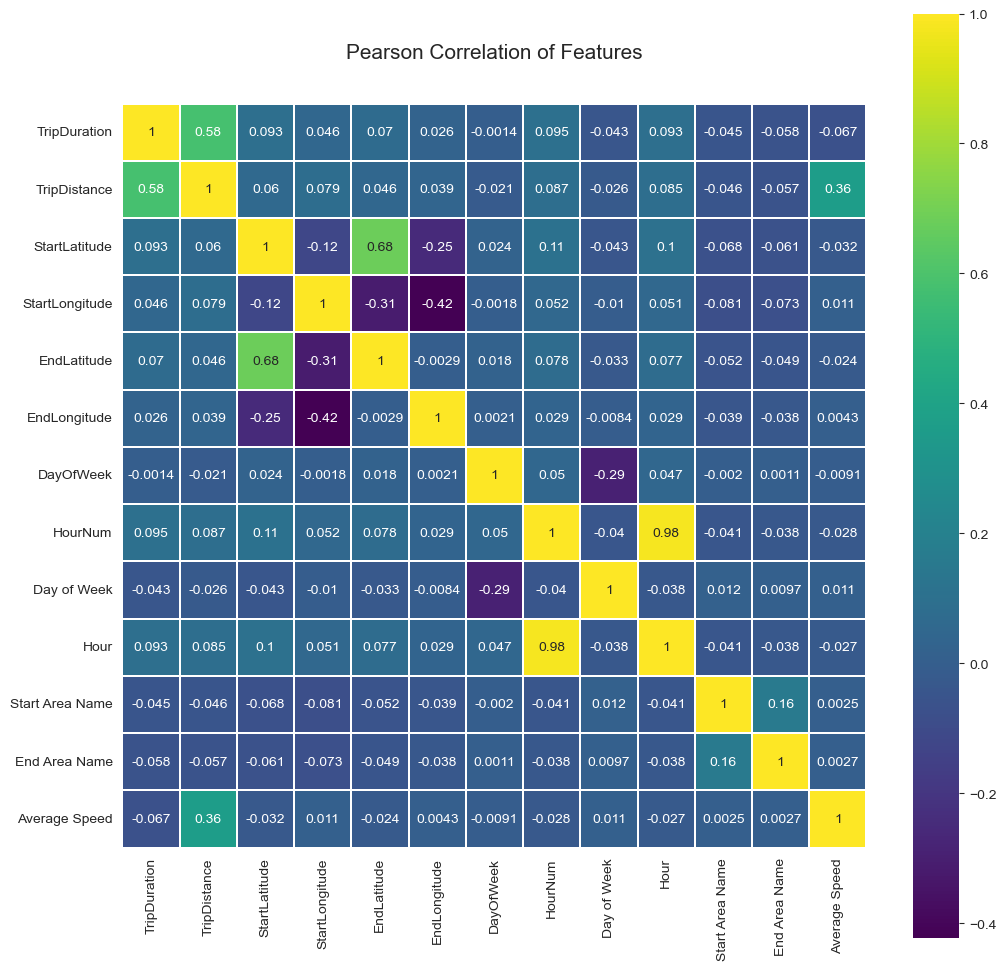

In [133]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)